# Facial Emotion Recogination

## importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

## Importing Dataset

In [2]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


### PLot of number of images in training set

<AxesSubplot:>

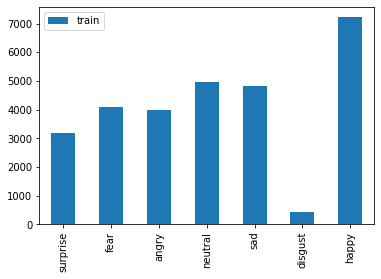

In [3]:
train_count.transpose().plot(kind='bar')

### PLot of number of images in test set

<AxesSubplot:>

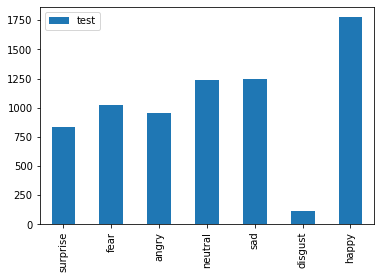

In [4]:
test_count.transpose().plot(kind='bar')

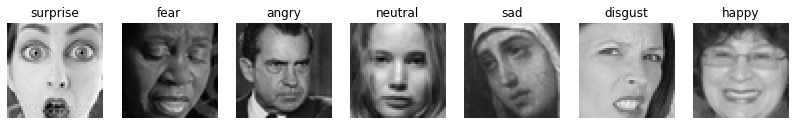

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Creating Training and test sets

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Defining Model

In [8]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [9]:
fernet = get_model((row,col,1), classes)
fernet.summary()

2022-08-31 06:23:44.647018: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


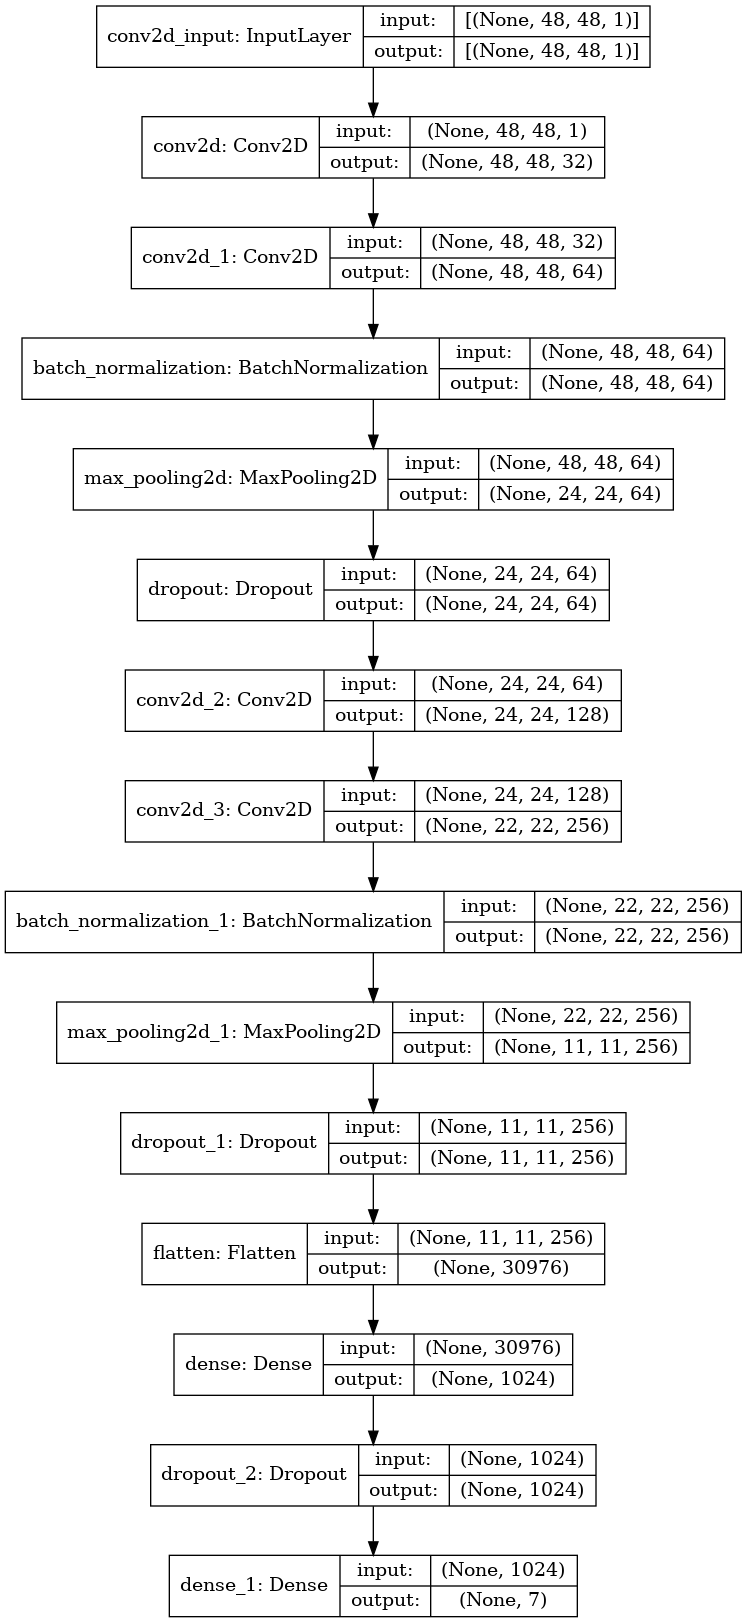

In [10]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

### Callbacks Function

In [11]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

2022-08-31 06:23:46.359080: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-31 06:23:46.359241: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-31 06:23:46.360421: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


## Training Model

In [12]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=20,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

2022-08-31 06:23:46.846026: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
448/448 [==============================] - 528s 1s/step - loss: 4.3186 - accuracy: 0.2809 - val_loss: 7.7488 - val_accuracy: 0.0499

Epoch 00001: val_loss improved from inf to 7.74883, saving model to ferNet.h5
Epoch 2/20
448/448 [==============================] - 520s 1s/step - loss: 3.5209 - accuracy: 0.3383 - val_loss: 3.1308 - val_accuracy: 0.4007

Epoch 00002: val_loss improved from 7.74883 to 3.13083, saving model to ferNet.h5
Epoch 3/20
448/448 [==============================] - 516s 1s/step - loss: 2.9836 - accuracy: 0.3775 - val_loss: 2.7004 - val_accuracy: 0.4219

Epoch 00003: val_loss improved from 3.13083 to 2.70042, saving model to ferNet.h5
Epoch 4/20
448/448 [==============================] - 515s 1s/step - loss: 2.5654 - accuracy: 0.4022 - val_loss: 2.2568 - val_accuracy: 0.4713

Epoch 00004: val_loss improved from 2.70042 to 2.25682, saving model to ferNet.h5
Epoch 5/20
448/448 [==============================] - 516s 1s/step - loss: 2.2449 - accuracy: 0.4287

## Loss and Accuracy plot

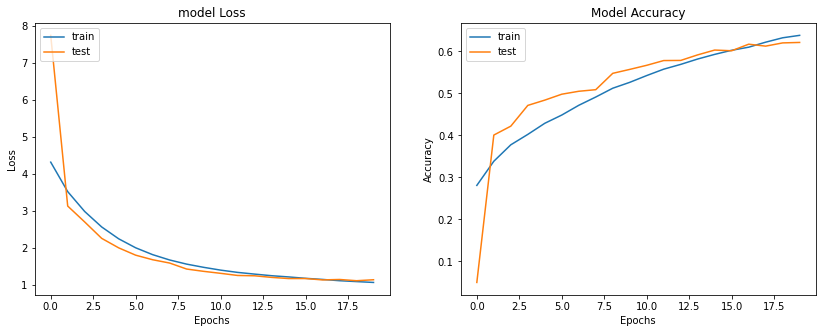

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("loss_accuracy_graph_updated.png")
plt.show()


high accracy is achieved on training set but accuracy on validation set is stuck at 66% also no overfitting can se seen in the dataset hence is can be concluded that the inefficiency may be due to the unbalanced dataset

### Model evaluation

In [14]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 36s 321ms/step - loss: 1.1376 - accuracy: 0.6209
final train accuracy = 69.87 , validation accuracy = 62.09


In [15]:
fernet.save_weights('fernet_bestweight.h5')

### Confusion Matrix and Classification on training set

Confusion Matrix
[[ 514   16  401 1078  796  738  452]
 [  55    3   41  115   92   84   46]
 [ 481   25  412 1152  891  674  462]
 [ 864   48  685 1978 1525 1250  865]
 [ 626   28  468 1392 1047  859  545]
 [ 612   33  515 1338  981  835  516]
 [ 381   12  303  882  649  543  401]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.13      0.14      3995
     disgust       0.02      0.01      0.01       436
        fear       0.15      0.10      0.12      4097
       happy       0.25      0.27      0.26      7215
     neutral       0.18      0.21      0.19      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.12      0.13      0.12      3171

    accuracy                           0.18     28709
   macro avg       0.15      0.15      0.14     28709
weighted avg       0.18      0.18      0.18     28709



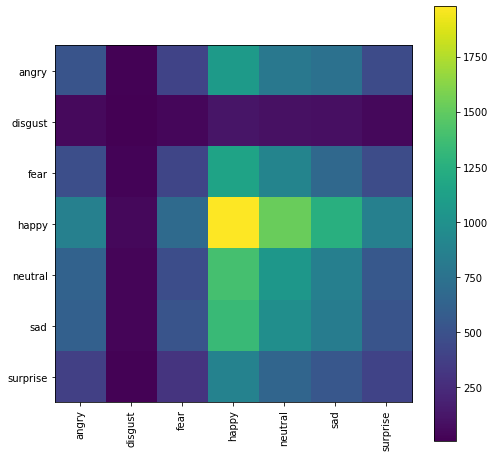

In [16]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Confusion Matrix and Classification on test set

Confusion Matrix
[[138   2  81 250 221 149 117]
 [ 14   1  10  36  17  22  11]
 [142   1  90 268 232 153 138]
 [247   8 176 487 443 227 186]
 [164   5 117 326 276 204 141]
 [163   7 128 355 278 175 141]
 [119   0  98 213 180 117 104]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14       958
     disgust       0.04      0.01      0.01       111
        fear       0.13      0.09      0.10      1024
       happy       0.25      0.27      0.26      1774
     neutral       0.17      0.22      0.19      1233
         sad       0.17      0.14      0.15      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.18      7178
   macro avg       0.15      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



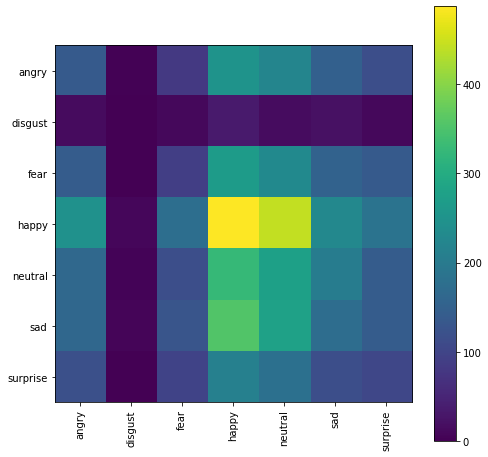

In [17]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)